![logo](./img/LogoLine_horizon_CAMS.png)

<br>

# Vertical Cross Section Plot

### About

This notebook provides you a practical introduction to the CAMS global atmospheric composition forecasts on single and pressure levels. We will use the data to analyse the transport of large plumes of sulphur dioxide over the Atlantic Ocean, after the eruptions of the Cumbre Vieja Volcano on La Palma in the Canary Islands on 19 September 2021. We first animate the plumes of the total column Sulphur Dioxide during October 2021. Afterwards, we will create a vertical cross-section plot of Sulphur Dioxide on different pressure levels to better assess the vertical distribution of SO<sub>2</sub> in the atmosphere over the Atlantic Ocean in October 2021.

The notebook has the following outline:

* 1 - Request data from the ADS programmatically with the CDS API
* 2 - Unzip the downloaded data file
* 3 - Animation of total column sulphur dioxide over the Atlantic Ocean in October 2021
* 4 - Compute meridional mean plot of Sulphur Dioxide over the Atlantic Ocean in October 2021

### Data

This notebook introduces you to the [CAMS global atmospheric composition forecasts and analyses](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview). The data has the following specifications:

> **Data**: `CAMS global atmospheric composition forecasts` <br>
> **Variables**: `['sulphur_dioxide', 'total_column_sulphur_dioxide']` <br>
> **Temporal coverage**: `1 to 31 October 2021` <br>
> **Spatial coverage**: `Geographical subset: N:60, W:-90, S:10, E:0` <br>
> **Level**: `surface and pressure levels` <br>
> **Format**: `zipped NetCDF`


### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/CAMS_vertical-cross-section-volcanic-eruption.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/CAMS_vertical-cross-section-volcanic-eruption.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/CAMS_vertical-cross-section-volcanic-eruption.ipynb)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/CAMS_vertical-cross-section-volcanic-eruption.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install [Xarray](http://xarray.pydata.org/en/stable/) for working with multidimensional data in netcdf files, and the ADS API (`pip install cdsapi`) for downloading data programatically from the ADS.

### Further resources
* [CAMS monitors transport of SO2 from La Palma volcano](https://atmosphere.copernicus.eu/cams-monitors-transport-so2-la-palma-volcano)

<hr>

### Install CDSAPI via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [3]:
# CDS API
import cdsapi
import os

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load helper functions

In [12]:
def visualize_pcolormesh(data_array, longitude, latitude, projection, color_scale, unit, long_name, vmin, vmax, 
                         set_global=True, lonmin=-180, lonmax=180, latmin=-90, latmax=90):
    """ 
    Visualizes a xarray.DataArray with matplotlib's pcolormesh function.
    
    Parameters:
        data_array(xarray.DataArray): xarray.DataArray holding the data values
        longitude(xarray.DataArray): xarray.DataArray holding the longitude values
        latitude(xarray.DataArray): xarray.DataArray holding the latitude values
        projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        color_scale(str): string taken from matplotlib's color ramp reference
        unit(str): the unit of the parameter, taken from the NetCDF file if possible
        long_name(str): long name of the parameter, taken from the NetCDF file if possible
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
        set_global(boolean): optional kwarg, default is True
        lonmin,lonmax,latmin,latmax(float): optional kwarg, set geographic extent is set_global kwarg is set to 
                                            False

    """
    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=projection)
   
    img = plt.pcolormesh(longitude, latitude, data_array, 
                        cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax,
                        shading='auto')

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    if (projection==ccrs.PlateCarree()):
        ax.set_extent([lonmin, lonmax, latmin, latmax], projection)
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.top_labels=False
        gl.right_labels=False
        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'size':14}
        gl.ylabel_style={'size':14}

    if(set_global):
        ax.set_global()
        ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(long_name, fontsize=20, pad=20.0)

    return fig, ax

<hr>

## 1. Request data from the ADS programmatically with the CDS API

Let us request data from the Atmosphere Data Store programmatically with the help of the CDS API. We again set manually he CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal ADS key. Please find [here](https://ads.atmosphere.copernicus.eu/api-how-to) your personal ADS key.

In [5]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'
KEY = '######################################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we request analysis data from the `CAMS global atmospheric composition forecast` dataset. We request Sulphur Dioxide on single levels (`total_column_sulphur_dioxide`) and on different pressure levels (`sulphur dioxide`) for the month of October 2021 for a geographical subset over the Atlantic Ocean.

Let us store the dataset under the name `202110_global_analysis_so2.netcdf_zip`.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': [
            'sulphur_dioxide', 'total_column_sulphur_dioxide',
        ],
        'date': '2021-10-01/2021-10-30',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'type': 'forecast',
        'area': [
            60, -90, 10,
            0,
        ],
        'format': 'netcdf_zip',
        'pressure_level': [
            '200', '250', '300',
            '400', '500', '600',
            '700', '800', '850',
            '900', '925', '950',
            '1000',
        ],
    },
    './data/cams/202110_global_analysis_so2.netcdf_zip')

<br>

## 2. Unzip the downloaded data file

The CAMS global atmospheric composition forecasts can be retrieved from the Atmosphere Data Store in two data formats, `GRIB` and `Zipped netCDF`. We downloaded the data as `Zipped netCDF` (see CDSAPI request [here](./200_atmosphere_data_store_intro.ipynb#cams_forecast_pl_so2)) and for this reason, before we can load any data, we have to unzip the files. You can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

From the zip archive, two `NetCDF` files are extracted: one with the name ending `_pl`, which contains the SO<sub>2</sub> values on the chosen pressure levels and one with the name ending `_sfc`, which contains the total column SO<sub>2</sub> values. 

In [5]:
import zipfile
with zipfile.ZipFile('./202110_global_analysis_so2.netcdf_zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

## 2. Animation of total column sulphur dioxide over the Atlantic Ocean in October 2021

As a first step, we want to load the `total column sulphur dioxide` and animate the variable over the Atlantic Ocean in October 2021. Once the data has been extracted from the zip archive, you can load the NetCDF file with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. The function loads a `xarray.Dataset`, which is a collection of one or more data variables that share the same dimensions. You see that the data file has three dimensions, `latitude`, `longitude` and `time` and one variable, `tcso2. 

In [4]:
ds_so2_tc = xr.open_dataset('./levtype_sfc.nc')
ds_so2_tc

<xarray.Dataset>
Dimensions:    (latitude: 126, longitude: 226, time: 60)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00
Data variables:
    tcso2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-14 09:10:27 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

<br>

Let us now extract from the Dataset above the data variable `tcso2` as `xarray.DataArray`. You can load a data array from a xarray.Dataset by specifying the name of the variable (`tcso2`) in square brackets. A `xarray.DataArray` object offers us also additional metadata information, such as the `units` and `long_name` attributes.

In [5]:
da_so2_tc = ds_so2_tc['tcso2']
da_so2_tc

<xarray.DataArray 'tcso2' (time: 60, latitude: 126, longitude: 226)>
[1708560 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00
Attributes:
    units:          kg m**-2
    long_name:      Total column Sulphur dioxide
    standard_name:  atmosphere_mass_content_of_sulfur_dioxide

<br>

From the `units` attribute above, we see that the `Total column Sulphur dioxide` values are provided in `kg m**-2`, which is the SI unit. However, the concentration of a certain trace gas, such as SO<sub>2</sub>, in a column of air in the Earth's atmosphere is often given in `Dobson Units [DU]`. The `Dobson Unit` indicates how much of a given trace gas there is in the air above a certain point on earth. For SO<sub>2</sub>, the typical background level concentration (i.e. away from emissions related to pollution and volcanic eruptions) is much less than 1 DU. Emissions related to pollution and small volcanic eruptions are of the order of 1 DU or a few DU. Strong and explosive eruptions may lead to concentrations well above 10 DU, even as high as 100 DU.

In a next step, we would like to convert the SO<sub>2</sub>values from `kg m**-2` to `Dobson Units`. The conversion rate is as follows:
* `1 Dobson Unit [DU] is equal to 2.1415 x 10-5 kg[SO2]/m2`

Thus, to convert the SO<sub>2</sub> to DU, we have to divide the SO<sub>2</sub> by 2.1415*10**-5.

**Note:** this conversion leads to a drop of the data array attributes, as we modified the data values.

In [6]:
da_so2_tc_du = da_so2_tc / (2.1415*10**-5)
da_so2_tc_du

<xarray.DataArray 'tcso2' (time: 60, latitude: 126, longitude: 226)>
array([[[0.06780384, 0.05506284, 0.04157166, ..., 0.03032968,
         0.02695791, 0.02395987],
        [0.0644307 , 0.05243989, 0.04157166, ..., 0.03445301,
         0.03107987, 0.02770674],
        [0.06105756, 0.04981695, 0.04007399, ..., 0.03857497,
         0.03632576, 0.03332772],
        ...,
        [0.02920576, 0.02433496, 0.02283594, ..., 0.0198379 ,
         0.01908907, 0.01346808],
        [0.09890545, 0.07529758, 0.05019069, ..., 0.0194628 ,
         0.0149671 , 0.0123428 ],
        [0.10490154, 0.09628251, 0.1015284 , ..., 0.01421691,
         0.01159397, 0.01121887]],

       [[0.05506284, 0.05581167, 0.05656186, ..., 0.04869166,
         0.04869166, 0.04944186],
        [0.05731069, 0.05806088, 0.05993364, ..., 0.04869166,
         0.04869166, 0.04981695],
        [0.05993364, 0.06105756, 0.06293168, ..., 0.04681891,
         0.04606872, 0.04644381],
...
        [1.0555904 , 1.0945622 , 1.0016291 , ..., 0.09815662,
         0.10864841, 0.11876646],
        [1.0642087 , 1.0357294 , 0.84799033, ..., 0.0970327 ,
         0.10527663, 0.11277038],
        [0.73144865, 0.66886896, 0.5272217 , ..., 0.08728974,
         0.09178545, 0.09628251]],

       [[0.0970327 , 0.09815662, 0.09890545, ..., 0.07867072,
         0.07229954, 0.06705365],
        [0.0891625 , 0.09216055, 0.09553368, ..., 0.08166876,
         0.07529758, 0.06742875],
        [0.08016974, 0.08616446, 0.09178545, ..., 0.08354151,
         0.07829562, 0.06967659],
        ...,
        [0.14012648, 0.12626156, 0.1090235 , ..., 0.1337553 ,
         0.14911924, 0.16485828],
        [0.11951665, 0.11989038, 0.11651861, ..., 0.12438744,
         0.1337553 , 0.14949434],
        [0.11539332, 0.11164645, 0.12026548, ..., 0.11014743,
         0.12064058, 0.13787727]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00

<br>

The next step is to re-assign the attributes from before and to change the `units` attribute to `DU` for Dobosn unit. You can re-assign attributes to a data array with the function `assign_attrs()`.

In [7]:
da_so2_tc_du = da_so2_tc_du.assign_attrs(da_so2_tc.attrs)
da_so2_tc_du.attrs['units'] = 'DU'

<br>

And now we can plot the `Total column Sulphur Dioxide` values in Dobson Unit with matplotlib's function `pcolormesh()`.The visualisation code below can be split in four main parts:
* **Initiate a matplotlib figure:** with `plt.figure()` and an axes object
* **Plotting function**: plot the data array with the matplotlib function `pcolormesh()`
* **Add additional mapping features**: such as coastlines, grid or a colorbar
* **Set a title of the plot**: you can combine the `species name` and `time` information for the title

Text(0.5, 1.0, 'Total column Sulphur dioxide - 2021-10-06T00:00:00.000000000\n')

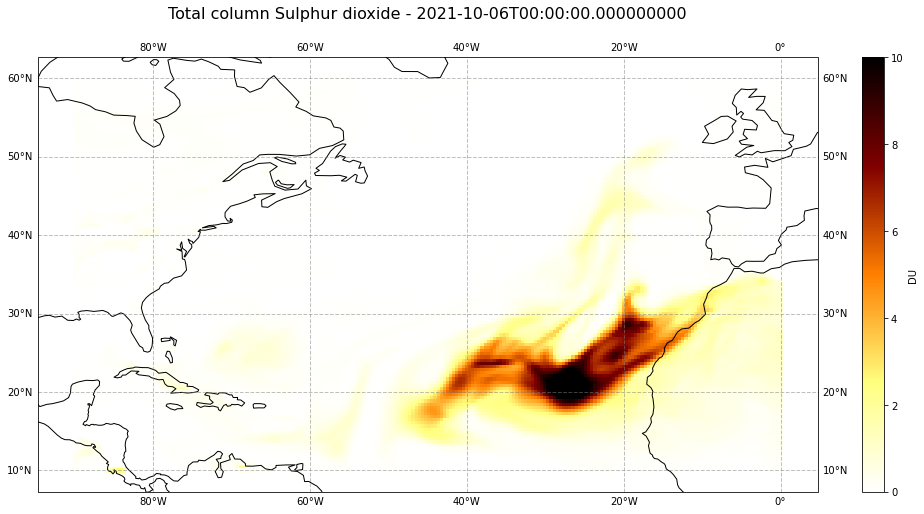

In [8]:
time_index =  10

# Initiate the matplotlib figure
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function with pcolormesh
im = plt.pcolormesh(da_so2_tc_du.longitude, 
                    da_so2_tc_du.latitude, 
                    da_so2_tc_du[time_index,:,:],
                    cmap='afmhot_r', 
                    transform=ccrs.PlateCarree(), 
                    vmin=0, 
                    vmax=10)

# Add additional mapping features
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label(da_so2_tc_du.units)

# Set a title of the plot
ax.set_title(da_so2_tc_du.long_name + ' - ' + str(da_so2_tc_du.time[time_index].values)+'\n', fontsize=16)

<br>

In the last step, you can animate the `Total column Sulphur Dioxide in DU` in order to see how the trace gas develops over the Atlantic in October 2021.
You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [16]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=da_so2_tc_du[0,:,:],
                               longitude=da_so2_tc_du.longitude, 
                               latitude=da_so2_tc_du.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='afmhot_r', 
                               unit=da_so2_tc_du.units,
                               long_name=da_so2_tc_du.long_name + ' '+ str(da_so2_tc_du.time[0].data),
                               vmin=0,
                               vmax=10, 
                               lonmin=da_so2_tc_du.longitude.min(), 
                               lonmax=da_so2_tc_du.longitude.max(), 
                               latmin=da_so2_tc_du.latitude.min(), 
                               latmax=da_so2_tc_du.latitude.max(),
                               set_global=False)

frames = 59

def draw(i):
    img = plt.pcolormesh(da_so2_tc_du.longitude, 
                         da_so2_tc_du.latitude, 
                         da_so2_tc_du[i,:,:], 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=10,
                         shading='auto')
    
    ax.set_title(da_so2_tc_du.long_name + ' '+ str(da_so2_tc_du.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=500, blit=False,
                              init_func=init, repeat=True)


HTML(ani.to_html5_video())
plt.close(fig)

In [19]:
HTML(ani.to_html5_video())

<br>

## 3. Compute meridional mean plot of Sulphur Dioxide over the Atlantic Ocean in October 2021

The next step is now to load the Sulphur Dioxide on different pressure levels to create a meridional mean plot to visualise the changing concentrations of SO<sub>2</sub> at different longitudes and at various pressure levels of the atmosphere. We will focus on the latitudes between 20 and 40 degrees and average over the latitudinal axis. This allows us to visualise a two dimensional plot of SO<sub>2</sub> concentrations by longitude and altitude.


In a first step, we want to load the file with the ending `_pl`, which contains the Sulphur Dioxide values on different pressure levels. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read a NetCDF file. The result is a `xarray.Dataset` with four dimensions: `latitude`, `level`, `longitude` and `time`.

In [14]:
ds_so2 = xr.open_dataset('./levtype_pl.nc')
ds_so2

<xarray.Dataset>
Dimensions:    (latitude: 126, level: 13, longitude: 226, time: 60)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00
Data variables:
    so2        (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-14 09:10:26 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

<br>

The next step is to extract the data variable `so2`. You can extract a data variable as `xarray.DataArray` by specifying the name of the variable in square brackets. The loaded data array reveals additional attributes of the variable, such as `units` and `long_name`. 

In [15]:
da_so2 = ds_so2['so2']
da_so2

<xarray.DataArray 'so2' (time: 60, level: 13, latitude: 126, longitude: 226)>
[22211280 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Sulphur dioxide mass mixing ratio
    standard_name:  mass_fraction_of_sulfur_dioxide_in_air

<br>

Above, you see that the sulphur dioxide values on pressure levels are disseminated as mass mixing ratios in kg of gas / kg of air. Trace gas concentrations at a particular pressure level in the atmosphere are often given as a `volume mixing ratio`, or simply mixing ratio. This unit is defined as the ratio of the number density of the gas to the total number density of the atmosphere. 

In other words, the SO<sub>2</sub> volume mixing ratio is the density of SO<sub>2</sub> divided by the density of all constituents of the atmosphere in a unit volume (i.e. the number of molecules per unit volume).
Therefore, an SO<sub>2</sub> mixing ratio of 10**-9 means that the number density of SO<sub>2</sub> is 10**-9 times the total number density of air in a unit volume. Following the standard convention for the earth's troposphere and stratosphere, this mixing ratio equals 1 ppbv (parts per billion by volume).

To convert data from MMR to VMR you only need molar masses of dry air and molar mass of the atmospheric species. For SO<sub>2</sub> the formula is: 
* `VMR = 28.9644 / 64.0638 * 1e9 * MMR`

Find [here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710) more information about converting mass mixing ratio (MMR) to volume mixing ratio (VMR).

Below, we apply the formula above and convert the SO<sub>2</sub> values to volume mixing ratio. <br>
**Note:** You will see that the operation drops the data array's attributes. We will re-assign the attributes after some more pre-processing steps.

In [16]:
da_so2_vmr = 28.9644 / 64.0638 * 1e9 * da_so2
da_so2_vmr

<xarray.DataArray 'so2' (time: 60, level: 13, latitude: 126, longitude: 226)>
array([[[[2.44856142e-02, 4.28482182e-02, 6.12108223e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         [2.44856142e-02, 4.59129363e-02, 6.12108223e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         [2.44856142e-02, 4.59129363e-02, 6.42755404e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         ...,
         [4.28482182e-02, 5.20295203e-02, 6.12108223e-02, ...,
          1.53043112e-02, 1.53043112e-02, 1.22460192e-02],
         [3.97899263e-02, 4.28482182e-02, 4.28482182e-02, ...,
          1.53043112e-02, 1.22460192e-02, 1.22460192e-02],
         [6.12108223e-02, 4.89712283e-02, 3.97899263e-02, ...,
          1.53043112e-02, 1.22460192e-02, 1.22460192e-02]],

        [[1.07123755e-01, 1.04059041e-01, 1.01000749e-01, ...,
          1.53043112e-02, 1.53043112e-02, 1.53043112e-02],
         [1.10182047e-01, 1.07123755e-01, 1.01000749e-01, ...,
          1.22460192e-02, 1.22460192e-02, 1.22460192e-02],
         [1.13240339e-01, 1.07123755e-01, 9.79424566e-02, ...,
          1.53043112e-02, 1.53043112e-02, 1.22460192e-02],
...
          1.98936775e-01, 2.23415971e-01, 2.32597262e-01],
         [1.22421645e-01, 9.79424566e-02, 6.42755404e-02, ...,
          1.80574179e-01, 1.80574179e-01, 1.89755470e-01],
         [3.97899263e-02, 3.97899263e-02, 4.59129363e-02, ...,
          1.65269867e-01, 1.56088561e-01, 1.53030261e-01]],

        [[6.42755404e-02, 6.73338324e-02, 6.73338324e-02, ...,
          2.63205886e-01, 2.54024595e-01, 2.63205886e-01],
         [7.34568387e-02, 7.95734227e-02, 8.26381445e-02, ...,
          2.78503776e-01, 2.66264170e-01, 2.63205886e-01],
         [9.18194428e-02, 9.48777348e-02, 9.48777348e-02, ...,
          3.12170684e-01, 2.84626782e-01, 2.63205886e-01],
         ...,
         [2.50959873e-01, 2.29538977e-01, 1.98936775e-01, ...,
          1.92813769e-01, 2.17299387e-01, 2.23415971e-01],
         [2.05053359e-01, 1.34667665e-01, 9.48777348e-02, ...,
          1.74451157e-01, 1.71392873e-01, 1.86690763e-01],
         [5.50942384e-02, 4.59129363e-02, 5.81525303e-02, ...,
          1.59146845e-01, 1.49965554e-01, 1.49965554e-01]]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-10-01 ... 2021-10-30T12:00:00

<br>

In a next step, we create the daily averages of Sulphur Dioxide in the atmosphere over the Atlantic. The xarray function `resample()` allows us to resample the time dimension from a 12-hourly resolution to a daily average. With the function `resample()` you define the resolution and with a subsequent aggregation function (e.g. mean), you define the aggregation level.

In [17]:
da_so2_daily = da_so2_vmr.resample(time='1D').mean()
da_so2_daily

<xarray.DataArray 'so2' (time: 30, level: 13, latitude: 126, longitude: 226)>
array([[[[2.90762652e-02, 3.82575691e-02, 4.59097214e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         [2.90762652e-02, 3.82607803e-02, 4.43805754e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         [2.90762652e-02, 3.82607803e-02, 4.59129363e-02, ...,
          3.06471740e-03, 3.06471740e-03, 3.06471740e-03],
         ...,
         [1.91281408e-01, 1.62208363e-01, 1.48436397e-01, ...,
          1.53043112e-02, 1.53043112e-02, 1.22460192e-02],
         [1.98933557e-01, 1.68328166e-01, 1.34664446e-01, ...,
          1.53043112e-02, 1.22460192e-02, 1.22460192e-02],
         [2.01995060e-01, 1.69860512e-01, 1.17830992e-01, ...,
          1.37751652e-02, 1.22460192e-02, 1.22460192e-02]],

        [[8.11089948e-02, 8.41672868e-02, 8.72287899e-02, ...,
          1.22460192e-02, 1.37751652e-02, 1.53043112e-02],
         [9.02870893e-02, 9.18194428e-02, 9.02870893e-02, ...,
          1.07168732e-02, 1.22460192e-02, 1.37751652e-02],
         [9.64068770e-02, 9.33485925e-02, 8.72287899e-02, ...,
          1.22460192e-02, 1.37751652e-02, 1.37751652e-02],
...
          2.09647223e-01, 2.23415971e-01, 2.44840071e-01],
         [1.08649686e-01, 1.05591401e-01, 7.80474916e-02, ...,
          1.86693966e-01, 1.89755470e-01, 2.12708727e-01],
         [4.43805754e-02, 4.43805754e-02, 4.74420823e-02, ...,
          1.79041818e-01, 1.72922015e-01, 1.79041803e-01]],

        [[3.36701274e-02, 3.67284194e-02, 3.67284194e-02, ...,
          2.69325674e-01, 2.70854831e-01, 2.75445461e-01],
         [3.82607765e-02, 4.13190685e-02, 4.28514294e-02, ...,
          2.63202667e-01, 2.63202667e-01, 2.67796546e-01],
         [4.89712246e-02, 4.89712246e-02, 4.89712246e-02, ...,
          2.31068119e-01, 2.23419175e-01, 2.24948317e-01],
         ...,
         [1.80570960e-01, 1.79041818e-01, 1.77512676e-01, ...,
          1.82103321e-01, 1.94346130e-01, 1.86690763e-01],
         [1.36193603e-01, 9.94715989e-02, 8.11057836e-02, ...,
          1.53027058e-01, 1.46907255e-01, 1.56088561e-01],
         [6.12140372e-02, 5.50942384e-02, 5.81525303e-02, ...,
          1.40784249e-01, 1.25483155e-01, 1.25483155e-01]]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-10-01 2021-10-02 ... 2021-10-30
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 11.2 10.8 10.4 10.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

<br>

### 3.3. Compute meridional mean plot of Sulphur Dioxide on different pressure levels 

The next step is now to prepare the data in order to create a meridional mean plot to visualise the changing concentrations of SO<sub>2</sub> at different longitudes and at various pressure levels of the atmosphere. We will focus on the latitudinal zone between 20° and 40° and average over the latitudinal axis. This allows us to visualise a two dimensional plot of SO<sub>2</sub> by longitude and altitude.

The first step is to filter the data array for all latitude entries between 20° and 40°. The xarray function `where()` allows us to filter any dimension of a data array. You can specify the keyword argument `drop`, which drops the values that were filtered out by the operation.

The size of the latitude dimension of the resulting data array has decreased from 126 to 51 grid points.

In [18]:
so2_lat_area = da_so2_daily.where((da_so2_daily.latitude >= 20) & (da_so2_daily.latitude <= 40), drop=True)
so2_lat_area

<xarray.DataArray 'so2' (time: 30, level: 13, latitude: 51, longitude: 226)>
array([[[[0.03826078, 0.04284822, 0.04590973, ..., 0.02295968,
          0.02601797, 0.02754712],
         [0.03672842, 0.03672842, 0.04284822, ..., 0.02295968,
          0.02601797, 0.02601797],
         [0.03519928, 0.03519928, 0.03519928, ..., 0.02295968,
          0.02295647, 0.02448561],
         ...,
         [0.04897123, 0.04743887, 0.04590972, ..., 0.02295647,
          0.02295647, 0.02448561],
         [0.04897123, 0.04743887, 0.04744208, ..., 0.02295647,
          0.02295647, 0.02295647],
         [0.04591294, 0.04438058, 0.04285143, ..., 0.02295647,
          0.02295647, 0.02142732]],

        [[0.05815253, 0.06274318, 0.06121082, ..., 0.01530752,
          0.01530752, 0.01836582],
         [0.04590973, 0.04897123, 0.05356188, ..., 0.01071687,
          0.01377517, 0.01683667],
         [0.03826078, 0.03978993, 0.04285143, ..., 0.00918773,
          0.01224602, 0.01683667],
...
         [0.16833135, 0.482028  , 0.3305365 , ..., 1.4062877 ,
          1.3772146 , 1.3313081 ],
         [0.16680223, 0.26932567, 0.34124696, ..., 1.3772147 ,
          1.311413  , 1.253267  ],
         [0.21729617, 0.20964402, 0.25555372, ..., 1.3557904 ,
          1.2655065 , 1.1889946 ]],

        [[0.55701077, 0.72839725, 0.47743732, ..., 0.02142732,
          0.02295647, 0.21882853],
         [0.3488959 , 0.6319903 , 0.5707827 , ..., 0.02907627,
          0.07957664, 0.27697784],
         [0.25555372, 0.44989344, 0.62280905, ..., 0.05968168,
          0.1025299 , 0.28003612],
         ...,
         [0.16374071, 0.8860117 , 0.60291725, ..., 1.3527322 ,
          1.3328372 , 1.2991735 ],
         [0.15302706, 0.3733815 , 0.47437584, ..., 1.34508   ,
          1.2808077 , 1.2318429 ],
         [0.27391315, 0.21270552, 0.28615594, ..., 1.3481416 ,
          1.2502055 , 1.1706321 ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-10-01 2021-10-02 ... 2021-10-30
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * latitude   (latitude) float32 40.0 39.6 39.2 38.8 ... 21.2 20.8 20.4 20.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

In a last step before we are able to visualize the meridional mean plot of Sulphur Dioxide, we have to compute the average over the latitudinal axis. You can use the xarray function `mean()` to create the average over the `latitude` dimension. The result is then a data array with three dimensions: `time`, `level` and `longitude`.

In [19]:
so2_lat_area_mean = so2_lat_area.mean(dim="latitude")
so2_lat_area_mean

<xarray.DataArray 'so2' (time: 30, level: 13, longitude: 226)>
array([[[0.04228049, 0.04339038, 0.04369039, ..., 0.01851643,
         0.01986662, 0.02148672],
        [0.03456937, 0.03390936, 0.03264874, ..., 0.02076699,
         0.02208739, 0.02244751],
        [0.02967826, 0.02994849, 0.02952835, ..., 0.04510095,
         0.0370297 , 0.02904861],
        ...,
        [0.23430985, 0.23878062, 0.28384754, ..., 2.6154728 ,
         2.5735564 , 2.4489768 ],
        [0.37356094, 0.36068925, 0.41478768, ..., 2.5458918 ,
         2.502115  , 2.396889  ],
        [0.64576304, 0.4554137 , 0.43008977, ..., 2.250167  ,
         2.212541  , 2.1485715 ]],

       [[0.03561898, 0.03672931, 0.0381399 , ..., 0.01602662,
         0.01575651, 0.0156066 ],
        [0.04525135, 0.04246051, 0.04006009, ..., 0.01686609,
         0.01686609, 0.01704649],
        [0.04729129, 0.0336392 , 0.02985885, ..., 0.03177917,
         0.02667842, 0.0234677 ],
...
        [0.37188086, 0.3589189 , 0.29852   , ..., 1.8349035 ,
         1.7450399 , 1.7213668 ],
        [0.38325262, 0.4459923 , 0.3342853 , ..., 1.7420996 ,
         1.6531359 , 1.5859857 ],
        [0.34145647, 0.43195033, 0.29602975, ..., 1.7314482 ,
         1.5971773 , 1.5612019 ]],

       [[0.01434611, 0.01494634, 0.01590688, ..., 0.03213872,
         0.03075842, 0.02979838],
        [0.01878696, 0.01854672, 0.01869696, ..., 0.03189879,
         0.03129875, 0.03132885],
        [0.01845696, 0.0180668 , 0.01854735, ..., 0.0253882 ,
         0.02484831, 0.02403726],
        ...,
        [0.27880692, 0.3260944 , 0.3163127 , ..., 1.6119697 ,
         1.521746  , 1.4966323 ],
        [0.3270546 , 0.3813324 , 0.36005932, ..., 1.5129547 ,
         1.4491951 , 1.4536355 ],
        [0.35672882, 0.4143674 , 0.36693034, ..., 1.4618869 ,
         1.3891559 , 1.4075187 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-10-01 2021-10-02 ... 2021-10-30
  * longitude  (longitude) float32 -90.0 -89.6 -89.2 ... -0.8 -0.4 2.033e-13
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

Let us now also add the attributes again to the data array, as we might want to use the `units` and `long_name` for title and label information in the resulting plot. Since we made various changes to the data array, we first can assign the attributes from the initial data array `da_so2`, but then modify and update specific attribute keys. The attributes we want to update are:
* `units`: `ppbv`
* `long_name`: `Sulphur dioxide volume mixing ratio`


In [20]:
so2_lat_area_mean = so2_lat_area_mean.assign_attrs(da_so2.attrs)
so2_lat_area_mean.attrs['long_name'] = 'Sulphur dioxide volume mixing ratio'
so2_lat_area_mean.attrs['units'] = 'ppbv'

so2_lat_area_mean.attrs

{'units': 'ppbv',
 'long_name': 'Sulphur dioxide volume mixing ratio',
 'standard_name': 'mass_fraction_of_sulfur_dioxide_in_air'}

<br>

### 3.4. Visualize the daily meridional mean of Sulphur Dioxide as cross-section plot

Now we can visualize the vertical Sulphur dioxide distribution over the Atlantic in October 2021. The pressure levels are on a non-linear scale. To ensure equal spacing between the values, let us create a regular scale.

In [21]:
y = np.arange(so2_lat_area_mean.level.shape[0])+1
y = y[::-1]

<br>

The visualization code can be divided in five main parts:
* **Initiate a matplotlib figure**: Initiatie a matplotlib figure object with `plt.figure()` and `plt.subplot()`
* **Plotting the data**: Plot the array with matplotlib's function `pcolormesh` with longitude on the x-axis and pressure levels on the y-axis
* **Set y-axis tickmarks and labels**: Set regular-scaled y-axis ticks and labels
* **Set axes labels and title**
* **Specify a colorbar**: Specify a colorbar to be placed on the right and use the units attribute to add to the colorbar as unit

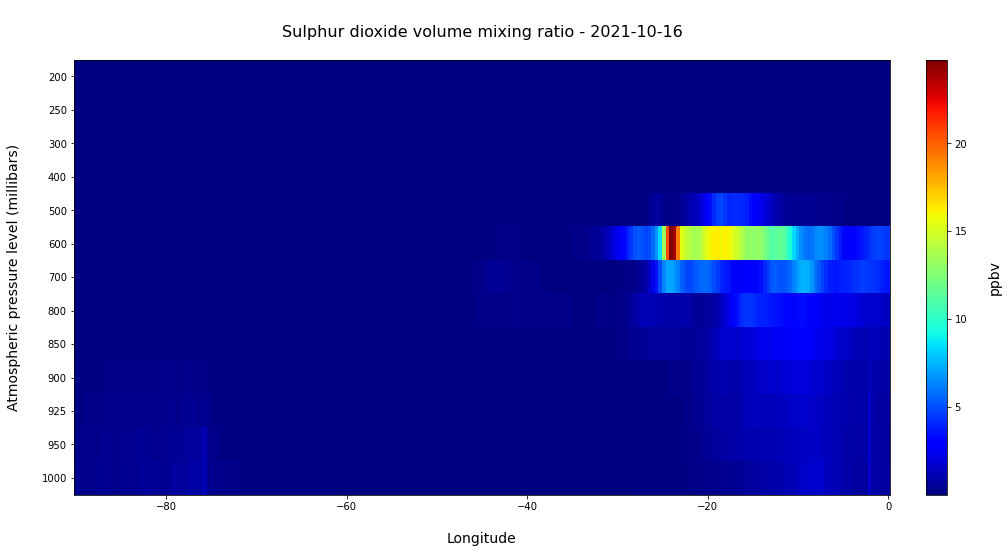

In [22]:
time_index = 15

# Define the figure and specify size
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot()

# Plot the figure with pcolormesh
im = plt.pcolormesh(so2_lat_area_mean.longitude, y, so2_lat_area_mean[time_index,:,:], cmap='jet', shading='auto')

# Set x and y axis tickmarks, labels
ax.yaxis.set_ticks(y)
ax.yaxis.set_ticklabels(so2_lat_area_mean.level.values)

# Set axes labels and title
ax.set_xlabel('\nLongitude', fontsize=14)
ax.set_ylabel('Atmospheric pressure level (millibars)\n', fontsize=14)
ax.set_title('\n'+ so2_lat_area_mean.long_name + ' - ' + str(so2_lat_area_mean.time[time_index].values)[0:10] + '\n', fontsize=16)

# Specify a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n'+ so2_lat_area_mean.units, fontsize=14)

The plot above shows you how the concentration and longitudinal distribution of Sulphur Dioxide over the Atlantic varies at different pressure levels and at different longitudes. You see that most of the SO<sub>2</sub> concentrations from the Cumbre Vieja Volcano eruption was transported over the Atlantic in higher atmospheric levels at a level between 700 to 400 millibars.

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>